In [1]:
import numpy as np

In [2]:
def pickle_data(data,name):
    import pickle
    f = open(name,'wb')
    pickle.dump(data,f)
    
def unpickle_data(name):
    import pickle
    o = open(name,'rb')
    data = pickle.load(o,encoding='bytes')
    return data

In [3]:
data = unpickle_data('Squeeze-HEDx256.pickle')

In [4]:
Ydata = unpickle_data('Squeeze-HED-defused-Y.pickle')

In [5]:
Ycan = unpickle_data('Cannyx256.pickle')

In [6]:
X = data['X']
Y = Ydata['Y']
YCan = Ycan['YCan']

In [7]:
Y = Y.reshape(-1,256,256,1)
YCan = YCan.reshape(-1,256,256,1)
Y = np.array(Y, bool)
Y = np.array(Y, int)
YCan = np.array(YCan,bool)
YCan = np.array(YCan,int)

# Directories

In [8]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d, upsample_2d, conv_2d_transpose, upsample_2d 
from tflearn.layers.core import input_data, dropout, fully_connected, flatten, activation
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge
from tflearn.activations import sigmoid
import numpy as np
import tensorflow as tf
import os

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [9]:
def fire(x, pipe, out):
    x = conv_2d(x, pipe, 1, activation='relu')
    y_ = conv_2d(x, out/2, 1, activation='relu')
    y__ = conv_2d(x, out/2, 3, activation='relu')
    y = merge([y_, y__], 'concat', axis=-1)
    return y

In [10]:
def d_fire(x, pipe, out):
    x_ = conv_2d(x, pipe/2, 3, activation='relu')
    x__ = conv_2d(x, pipe/2, 1, activation='relu')
    x = merge([x_, x__], 'concat', axis=-1)
    y = conv_2d(x, out, 1, activation='relu')
    return y

In [11]:
def edge_merge(current, past, features):
    x_ = conv_2d(current, features*3/4, 1, activation='relu')
    x__ = conv_2d(past, features/4, 1, activation='relu')
    y = merge([x_, x__], 'concat', axis=-1)
    return y

In [12]:
def side_branch(x, factor, n):
    x = conv_2d(x, 1, 1, activation='linear')
    kernel_size = 2*factor
    x = conv_2d_transpose(x, n, kernel_size, output_shape=[256,256], strides=factor, bias=False, activation='linear')
    return x

# Model Variables

In [17]:
LR = 1e-3
MODEL_NAME = '{}-v{}-{}-{}.model'.format('HED-Squeezed-256','13','balanced',LR)

# Model Architecture

### version 15

In [14]:
tf.reset_default_graph()


#Canny Fitting
net = input_data(shape=[None, 256, 256, 3], name='input_data')
print('input ---'+str(net.shape))

inet = conv_2d(net, 32, 3, activation='relu', name='first')
inet = max_pool_2d(inet, 2, strides=2)

conv1 = conv_2d(net, 8, 1, activation='relu', name='first')
conv1 = conv_2d(conv1, 32, 3, activation='relu', name='first')
bi1 = conv_2d(conv1, 8, 1, activation='relu', name='first')
print(bi1.shape)

conv2 = conv_2d(bi1, 32, 3, strides=2, activation='relu', name='first')
print(conv2.shape)
f1b0 = fire(conv2, 4, 32)
f2b0 = fire(f1b0, 4, 32)
print(str(f2b0.shape) + '---- f2b0')
b0 = side_branch(f2b0, 2, 4)
print(str(b0.shape) + '---- b0')

renet = merge([inet,  f2b0], 'concat', axis=-1, name='renet')
print(str(renet.shape) + '---- renet')

f1b1 = fire(renet, 8, 64)
f2b1 = fire(f1b1, 8, 64)
print(str(f2b1.shape) + '---- fb1')
b1 = side_branch(f2b1, 2, 4)
print(str(b1.shape) + '---- b1')
b1pool = max_pool_2d(f2b1, 2, strides=2, name='b1pool')
print(str(b1pool.shape) + '---- b1pool')

f1b2 = fire(b1pool, 16, 128)
f2b2 = fire(f1b2, 16, 128)
print(str(f2b2.shape) + '---- fb2')
b2 = side_branch(f2b2, 4, 2)
print(str(b2.shape) + '---- b2')
b2pool = max_pool_2d(f2b2, 2, strides=2, name='b2pool')
print(str(b2pool.shape) + '---- b2pool')

f1b3 = fire(b2pool, 32, 256)
f2b3 = fire(f1b3, 32, 256)
f3b3 = fire(f2b3, 32, 256)
print(str(f3b3.shape) + '---- fb3')
b3 = side_branch(f3b3, 8, 2)
print(str(b3.shape) + '---- b3')

bfuse = merge([bi1, b0, b1, b2, b3], 'concat', axis=-1, name='merge')
print(str(bfuse.shape) + '---- bfuse')

bfuse = conv_2d(bfuse, 32, 3, activation='relu', name='aftermerge')
bfuse = conv_2d(bfuse, 32, 3, activation='relu', name='aftermerge-2')
print(str(bfuse.shape)+'--------bfuse after merge')

bfuse = conv_2d(bfuse, 1, 1, bias=False, activation='linear', name='fuse_conv')
print(str(bfuse.shape) + '---- bfuse_conv')

convoi1 = conv_2d(bi1, 1, 1, activation='relu', name='squashedbi1')
convo0 = conv_2d(b0, 1, 1, activation='relu', name='squashedb0')
convo1 = conv_2d(b1, 1, 1, activation='relu', name='squashedb1')
convo2 = conv_2d(b2, 1, 1, activation='relu', name='squashedb2')
convo3 = conv_2d(b3, 1, 1, activation='relu', name='squashedb3')

oi1 = activation(convoi1, activation='sigmoid', name='oi1')
o0 = activation(convo0, activation='sigmoid', name='o0')
o1 = activation(convo1, activation='sigmoid', name='o1')
o2 = activation(convo2, activation='sigmoid', name='o2')
o3 = activation(convo3, activation='sigmoid', name='o3')
ofuse = activation(bfuse, activation='sigmoid', name='ofuse')

ei1 = regression(oi1, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='ei1')
e0 = regression(o0, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e0')
e1 = regression(o1, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e1')
e2 = regression(o2, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e2')
e3 = regression(o3, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e3')
efuse = regression(ofuse, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='efuse')



net = merge([oi1, o0, o1, o2, o3, ofuse], 'concat', axis=0)
print(net.shape)

model = tflearn.DNN(net, checkpoint_path=MODEL_NAME, max_checkpoints=1, tensorboard_verbose=0)

input ---(?, 256, 256, 3)
(?, 256, 256, 8)
(?, 128, 128, 32)
(?, 128, 128, 32)---- f2b0
(?, 256, 256, 4)---- b0
(?, 128, 128, 64)---- renet
(?, 128, 128, 64)---- fb1
(?, 256, 256, 4)---- b1
(?, 64, 64, 64)---- b1pool
(?, 64, 64, 128)---- fb2
(?, 256, 256, 2)---- b2
(?, 32, 32, 128)---- b2pool
(?, 32, 32, 256)---- fb3
(?, 256, 256, 2)---- b3
(?, 256, 256, 20)---- bfuse
(?, 256, 256, 32)--------bfuse after merge
(?, 256, 256, 1)---- bfuse_conv
(?, 256, 256, 1)


### version 14

In [15]:
tf.reset_default_graph()


#Canny Fitting
net = input_data(shape=[None, 256, 256, 1], name='input_data')
print('input ---'+str(net.shape))

inet = conv_2d(net, 32, 3, activation='relu', name='first')
inet = max_pool_2d(inet, 2, strides=2)

f1b0 = fire(inet, 4, 32)
f2b0 = fire(f1b0, 4, 32)
print(str(f2b0.shape) + '---- f2b0')
b0 = side_branch(f2b0, 2, 4)
print(str(b0.shape) + '---- b0')

renet = merge([inet,  f2b0], 'concat', axis=-1, name='renet')
print(str(renet.shape) + '---- renet')

f1b1 = fire(renet, 8, 64)
f2b1 = fire(f1b1, 8, 64)
print(str(f2b1.shape) + '---- fb1')
b1 = side_branch(f2b1, 2, 4)
print(str(b1.shape) + '---- b1')
b1pool = max_pool_2d(f2b1, 2, strides=2, name='b1pool')
print(str(b1pool.shape) + '---- b1pool')

f1b2 = fire(b1pool, 16, 128)
f2b2 = fire(f1b2, 16, 128)
print(str(f2b2.shape) + '---- fb2')
b2 = side_branch(f2b2, 4, 2)
print(str(b2.shape) + '---- b2')
b2pool = max_pool_2d(f2b2, 2, strides=2, name='b2pool')
print(str(b2pool.shape) + '---- b2pool')

f1b3 = fire(b2pool, 32, 256)
f2b3 = fire(f1b3, 32, 256)
f3b3 = fire(f2b3, 32, 256)
print(str(f3b3.shape) + '---- fb3')
b3 = side_branch(f3b3, 8, 2)
print(str(b3.shape) + '---- b3')

bfuse = merge([b0, b1, b2, b3], 'concat', axis=-1, name='merge')
print(str(bfuse.shape) + '---- bfuse')

bfuse = conv_2d(bfuse, 1, 1, bias=False, activation='linear', name='fuse_conv')
print(str(bfuse.shape) + '---- bfuse_conv')


convo0 = conv_2d(b0, 1, 1, activation='relu', name='squashedb0')
convo1 = conv_2d(b1, 1, 1, activation='relu', name='squashedb1')
convo2 = conv_2d(b2, 1, 1, activation='relu', name='squashedb2')
convo3 = conv_2d(b3, 1, 1, activation='relu', name='squashedb3')

o0 = activation(convo0, activation='sigmoid', name='o0')
o1 = activation(convo1, activation='sigmoid', name='o1')
o2 = activation(convo2, activation='sigmoid', name='o2')
o3 = activation(convo3, activation='sigmoid', name='o3')
ofuse = activation(bfuse, activation='sigmoid', name='ofuse')

e0= regression(o0, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e0')
e1 = regression(o1, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e1')
e2 = regression(o2, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e2')
e3 = regression(o3, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e3')
efuse = regression(ofuse, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='efuse')



net = merge([o0, o1, o2, o3, ofuse], 'concat', axis=0)
print(net.shape)

model = tflearn.DNN(net, checkpoint_path=MODEL_NAME, max_checkpoints=1, tensorboard_verbose=0)

input ---(?, 256, 256, 1)
(?, 128, 128, 32)---- f2b0
(?, 256, 256, 4)---- b0
(?, 128, 128, 64)---- renet
(?, 128, 128, 64)---- fb1
(?, 256, 256, 4)---- b1
(?, 64, 64, 64)---- b1pool
(?, 64, 64, 128)---- fb2
(?, 256, 256, 2)---- b2
(?, 32, 32, 128)---- b2pool
(?, 32, 32, 256)---- fb3
(?, 256, 256, 2)---- b3
(?, 256, 256, 12)---- bfuse
(?, 256, 256, 1)---- bfuse_conv
(?, 256, 256, 1)


### version 13

In [16]:
tf.reset_default_graph()


#Canny Fitting
net = input_data(shape=[None, 256, 256, 3], name='input_data')
print('input ---'+str(net.shape))

inet = conv_2d(net, 32, 3, activation='relu', name='first')
inet = max_pool_2d(inet, 2, strides=2)

conv1 = conv_2d(net, 8, 1, activation='relu', name='first')
conv1 = conv_2d(conv1, 32, 3, activation='relu', name='first')
bi1 = conv_2d(conv1, 8, 1, activation='relu', name='first')
print(bi1.shape)

conv2 = conv_2d(bi1, 32, 3, strides=2, activation='relu', name='first')
print(conv2.shape)
f1b0 = fire(conv2, 4, 32)
f2b0 = fire(f1b0, 4, 32)
print(str(f2b0.shape) + '---- f2b0')
b0 = side_branch(f2b0, 2, 4)
print(str(b0.shape) + '---- b0')

renet = merge([inet,  f2b0], 'concat', axis=-1, name='renet')
print(str(renet.shape) + '---- renet')

f1b1 = fire(renet, 8, 64)
f2b1 = fire(f1b1, 8, 64)
print(str(f2b1.shape) + '---- fb1')
b1 = side_branch(f2b1, 2, 4)
print(str(b1.shape) + '---- b1')
b1pool = max_pool_2d(f2b1, 2, strides=2, name='b1pool')
print(str(b1pool.shape) + '---- b1pool')

f1b2 = fire(b1pool, 16, 128)
f2b2 = fire(f1b2, 16, 128)
print(str(f2b2.shape) + '---- fb2')
b2 = side_branch(f2b2, 4, 2)
print(str(b2.shape) + '---- b2')
b2pool = max_pool_2d(f2b2, 2, strides=2, name='b2pool')
print(str(b2pool.shape) + '---- b2pool')

f1b3 = fire(b2pool, 32, 256)
f2b3 = fire(f1b3, 32, 256)
f3b3 = fire(f2b3, 32, 256)
print(str(f3b3.shape) + '---- fb3')
b3 = side_branch(f3b3, 8, 2)
print(str(b3.shape) + '---- b3')

bfuse = merge([bi1, b0, b1, b2, b3], 'concat', axis=-1, name='merge')
print(str(bfuse.shape) + '---- bfuse')

bfuse = conv_2d(bfuse, 1, 1, bias=False, activation='linear', name='fuse_conv')
print(str(bfuse.shape) + '---- bfuse_conv')

convoi1 = conv_2d(bi1, 1, 1, activation='relu', name='squashedbi1')
convo0 = conv_2d(b0, 1, 1, activation='relu', name='squashedb0')
convo1 = conv_2d(b1, 1, 1, activation='relu', name='squashedb1')
convo2 = conv_2d(b2, 1, 1, activation='relu', name='squashedb2')
convo3 = conv_2d(b3, 1, 1, activation='relu', name='squashedb3')

oi1 = activation(convoi1, activation='sigmoid', name='oi1')
o0 = activation(convo0, activation='sigmoid', name='o0')
o1 = activation(convo1, activation='sigmoid', name='o1')
o2 = activation(convo2, activation='sigmoid', name='o2')
o3 = activation(convo3, activation='sigmoid', name='o3')
ofuse = activation(bfuse, activation='sigmoid', name='ofuse')

ei1 = regression(oi1, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='ei1')
e0 = regression(o0, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e0')
e1 = regression(o1, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e1')
e2 = regression(o2, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e2')
e3 = regression(o3, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e3')
efuse = regression(ofuse, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='efuse')



net = merge([oi1, o0, o1, o2, o3, ofuse], 'concat', axis=0)
print(net.shape)

model = tflearn.DNN(net, checkpoint_path=MODEL_NAME, max_checkpoints=1, tensorboard_verbose=0)

input ---(?, 256, 256, 3)
(?, 256, 256, 8)
(?, 128, 128, 32)
(?, 128, 128, 32)---- f2b0
(?, 256, 256, 4)---- b0
(?, 128, 128, 64)---- renet
(?, 128, 128, 64)---- fb1
(?, 256, 256, 4)---- b1
(?, 64, 64, 64)---- b1pool
(?, 64, 64, 128)---- fb2
(?, 256, 256, 2)---- b2
(?, 32, 32, 128)---- b2pool
(?, 32, 32, 256)---- fb3
(?, 256, 256, 2)---- b3
(?, 256, 256, 20)---- bfuse
(?, 256, 256, 1)---- bfuse_conv
(?, 256, 256, 1)


### version 12

In [67]:
tf.reset_default_graph()

net = input_data(shape=[None, 256, 256, 3], name='input_data')
print('input ---'+str(net.shape))

conv1 = conv_2d(net, 16, 7, strides=2, activation='relu', name='first')
b0 = side_branch(conv1, 2, 4)
print(str(b0.shape) + '---- b0')

f1b1 = fire(conv1, 8, 64)
f2b1 = fire(f1b1, 8, 64)
print(str(f2b1.shape) + '---- fb1')
b1 = side_branch(f2b1, 2, 4)
print(str(b1.shape) + '---- b1')
b1pool = max_pool_2d(f2b1, 2, strides=2, name='b1pool')
print(str(b1pool.shape) + '---- b1pool')

f1b2 = fire(b1pool, 16, 128)
f2b2 = fire(f1b2, 16, 128)
print(str(f2b2.shape) + '---- fb2')
b2 = side_branch(f2b2, 4, 2)
print(str(b2.shape) + '---- b2')
b2pool = max_pool_2d(f2b2, 2, strides=2, name='b2pool')
print(str(b2pool.shape) + '---- b2pool')

f1b3 = fire(b2pool, 32, 256)
f2b3 = fire(f1b3, 32, 256)
f3b3 = fire(f2b3, 32, 256)
print(str(f3b3.shape) + '---- fb3')
b3 = side_branch(f3b3, 8, 2)
print(str(b3.shape) + '---- b3')
b3pool = max_pool_2d(f3b3, 2, strides=2, name='b3pool')
print(str(b3pool.shape) + '---- b3pool')

f1b4 = fire(b3pool, 64, 512)
f2b4 = fire(f1b4, 64, 512)
f3b4 = fire(f2b4, 64, 512)
print(str(f3b4.shape) + '---- fb4')
b4 = side_branch(f3b4, 16, 1)
print(str(b4.shape) + '---- b4')


bfuse = merge([b0, b1, b2, b3, b4], 'concat', axis=-1, name='merge')
print(str(bfuse.shape) + '---- bfuse')

bfuse = conv_2d(bfuse, 1, 1, bias=False, activation='linear', name='fuse_conv')
print(str(bfuse.shape) + '---- bfuse_conv')

convo0 = conv_2d(b0, 1, 1, activation='relu', name='squashedb0')
convo1 = conv_2d(b1, 1, 1, activation='relu', name='squashedb1')
convo2 = conv_2d(b2, 1, 1, activation='relu', name='squashedb2')
convo3 = conv_2d(b3, 1, 1, activation='relu', name='squashedb3')
convo4 = conv_2d(b4, 1, 1, activation='relu', name='squashedb4')


o0 = activation(convo0, activation='sigmoid', name='o0')
o1 = activation(convo1, activation='sigmoid', name='o1')
o2 = activation(convo2, activation='sigmoid', name='o2')
o3 = activation(convo3, activation='sigmoid', name='o3')
o4 = activation(convo4, activation='sigmoid', name='o4')
ofuse = activation(bfuse, activation='sigmoid', name='ofuse')

e0 = regression(o0, optimizer='adam', learning_rate=LR, loss='cross_entropy_balanced', name='e0')
e1 = regression(o1, optimizer='adam', learning_rate=LR, loss='cross_entropy_balanced', name='e1')
e2 = regression(o2, optimizer='adam', learning_rate=LR, loss='cross_entropy_balanced', name='e2')
e3 = regression(o3, optimizer='adam', learning_rate=LR, loss='cross_entropy_balanced', name='e3')
e4 = regression(o4, optimizer='adam', learning_rate=LR, loss='cross_entropy_balanced', name='e4')
efuse = regression(ofuse, optimizer='adam', learning_rate=LR, loss='cross_entropy_balanced', name='efuse')



net = merge([o0, o1, o2, o3, o4, ofuse], 'concat', axis=0)
print(net.shape)

model = tflearn.DNN(net, checkpoint_path=MODEL_NAME, max_checkpoints=1, tensorboard_verbose=0)

input ---(?, 256, 256, 3)
(?, 256, 256, 4)---- b0
(?, 128, 128, 64)---- fb1
(?, 256, 256, 4)---- b1
(?, 64, 64, 64)---- b1pool
(?, 64, 64, 128)---- fb2
(?, 256, 256, 2)---- b2
(?, 32, 32, 128)---- b2pool
(?, 32, 32, 256)---- fb3
(?, 256, 256, 2)---- b3
(?, 16, 16, 256)---- b3pool
(?, 16, 16, 512)---- fb4
(?, 256, 256, 1)---- b4
(?, 256, 256, 13)---- bfuse
(?, 256, 256, 1)---- bfuse_conv
(?, 256, 256, 1)


### Version 9

In [88]:
tf.reset_default_graph()

net = input_data(shape=[None, 256, 256, 3], name='input_data')
print('input ---'+str(net.shape))

conv1 = conv_2d(net, 16, 7, strides=2, activation='relu', name='first')

f1b1 = fire(conv1, 8, 64)
f2b1 = fire(f1b1, 8, 64)
print(str(f2b1.shape) + '---- fb1')
b1 = side_branch(f2b1, 2,1)
print(str(b1.shape) + '---- b1')
b1pool = max_pool_2d(f2b1, 2, strides=2, name='b1pool')
print(str(b1pool.shape) + '---- b1pool')

f1b2 = fire(b1pool, 8, 64)
f2b2 = fire(f1b2, 8, 64)
print(str(f2b2.shape) + '---- fb2')
b2 = side_branch(f2b2, 4,1)
print(str(b2.shape) + '---- b2')
b2pool = max_pool_2d(f2b2, 2, strides=2, name='b2pool')
print(str(b2pool.shape) + '---- b2pool')

f1b3 = fire(b2pool, 16, 128)
f2b3 = fire(f1b3, 16, 128)
f3b3 = fire(f2b3, 16, 128)
print(str(f3b3.shape) + '---- fb3')
b3 = side_branch(f3b3, 8,1)
print(str(b3.shape) + '---- b3')
b3pool = max_pool_2d(f3b3, 2, strides=2, name='b3pool')
print(str(b3pool.shape) + '---- b3pool')

f1b4 = fire(b3pool, 16, 128)
f2b4 = fire(f1b4, 16, 128)
f3b4 = fire(f2b4, 16, 128)
print(str(f3b4.shape) + '---- fb4')
b4 = side_branch(f3b4, 16,1)
print(str(b4.shape) + '---- b4')
b4pool = max_pool_2d(f3b4, 2, strides=2, name='b4pool')
print(str(b4pool.shape) + '---- b4pool')

f1b5 = fire(b4pool, 32, 256)
f2b5 = fire(f1b5, 32, 256)
f3b5 = fire(f2b5, 32, 256)
print(str(f3b5.shape) + '---- fb5')
b5 = side_branch(f3b5, 32,1)
print(str(b5.shape) + '---- b5')

bfuse = merge([b1, b2, b3, b4, b5], 'concat', axis=-1, name='merge')
print(str(bfuse.shape) + '---- bfuse')

bfuse = conv_2d(bfuse, 1, 1, bias=False, activation='linear', name='fuse_conv')
print(str(bfuse.shape) + '---- bfuse_conv')

o1 = activation(b1, activation='sigmoid', name='o1')
o2 = activation(b2, activation='sigmoid', name='o2')
o3 = activation(b3, activation='sigmoid', name='o3')
o4 = activation(b4, activation='sigmoid', name='o4')
o5 = activation(b5, activation='sigmoid', name='o5')
ofuse = activation(bfuse, activation='sigmoid', name='ofuse')

e1 = regression(o1, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e1')
e2 = regression(o2, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e2')
e3 = regression(o3, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e3')
e4 = regression(o4, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e4')
e5 = regression(o5, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='e5')
efuse = regression(ofuse, optimizer='adam', learning_rate=LR, loss='weighted_crossentropy', name='efuse')

net = merge([o1, o2, o3, o4, o5, ofuse], 'concat', axis=0)
print(net.shape)

model = tflearn.DNN(net, checkpoint_path=MODEL_NAME, max_checkpoints=1, tensorboard_verbose=0)

input ---(?, 256, 256, 3)
(?, 128, 128, 64)---- fb1
(?, 256, 256, 1)---- b1
(?, 64, 64, 64)---- b1pool
(?, 64, 64, 64)---- fb2
(?, 256, 256, 1)---- b2
(?, 32, 32, 64)---- b2pool
(?, 32, 32, 128)---- fb3
(?, 256, 256, 1)---- b3
(?, 16, 16, 128)---- b3pool
(?, 16, 16, 128)---- fb4
(?, 256, 256, 1)---- b4
(?, 8, 8, 128)---- b4pool
(?, 8, 8, 256)---- fb5
(?, 256, 256, 1)---- b5
(?, 256, 256, 5)---- bfuse
(?, 256, 256, 1)---- bfuse_conv
(?, 256, 256, 1)


# Training

### version 15

In [15]:
while(True):
    model.fit(X,{'ei1':YCan, 'e0':YCan,'e1':Y,'e2':Y,'e3':Y,'efuse':Y}, n_epoch=1, shuffle=True,
              show_metric=True, batch_size=16, snapshot_step=400,
              snapshot_epoch=False, run_id=MODEL_NAME)
    model.save(MODEL_NAME)

---------------------------------
Run id: HED-Squeezed-256-v15-balanced-0.001.model
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/Adam_0 (raw) is illegal; using Accuracy/Adam_0__raw_ instead.
INFO:tensorflow:Summary name Accuracy_1/Adam_1 (raw) is illegal; using Accuracy_1/Adam_1__raw_ instead.
INFO:tensorflow:Summary name Accuracy_2/Adam_0 (raw) is illegal; using Accuracy_2/Adam_0__raw_ instead.
INFO:tensorflow:Summary name Accuracy_3/Adam_1 (raw) is illegal; using Accuracy_3/Adam_1__raw_ instead.
INFO:tensorflow:Summary name Accuracy_4/Adam_0 (raw) is illegal; using Accuracy_4/Adam_0__raw_ instead.
INFO:tensorflow:Summary name Accuracy_5/Adam_1 (raw) is illegal; using Accuracy_5/Adam_1__raw_ instead.
---------------------------------
Training samples: 57600
Validation samples: 0
--


InternalError: Blas SGEMM launch failed : m=1048576, n=8, k=3
	 [[Node: first_1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_data/X_0/_15, first_1/W/read)]]
	 [[Node: Accuracy/Mean/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_355_Accuracy/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'first_1/Conv2D', defined at:
  File "C:\Users\Shachi Shah\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Shachi Shah\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-f29589141b30>", line 11, in <module>
    conv1 = conv_2d(net, 8, 1, activation='relu', name='first')
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tflearn\layers\conv.py", line 99, in conv_2d
    inference = tf.nn.conv2d(incoming, W, strides, padding)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 403, in conv2d
    data_format=data_format, name=name)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Shachi Shah\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas SGEMM launch failed : m=1048576, n=8, k=3
	 [[Node: first_1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_data/X_0/_15, first_1/W/read)]]
	 [[Node: Accuracy/Mean/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_355_Accuracy/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### version 14

In [29]:
while(True):
    model.fit(YCan,{'e0':Y,'e1':Y,'e2':Y,'e3':Y,'efuse':Y}, n_epoch=1, shuffle=True,
              show_metric=True, batch_size=16, snapshot_step=400,
              snapshot_epoch=False, run_id=MODEL_NAME)
    model.save(MODEL_NAME)

Training Step: 816  | total loss: 7.47546 | time: 1809.649s
| Adam_0 | epoch: 002 | loss: 1.50546 - acc: 0.0217 -- iter: 3456/9600
| Adam_1 | epoch: 002 | loss: 1.49493 - acc: 0.0969 -- iter: 3456/9600
| Adam_0 | epoch: 002 | loss: 1.50010 - acc: 0.0547 -- iter: 3456/9600
| Adam_1 | epoch: 002 | loss: 1.49638 - acc: 0.1606 -- iter: 3456/9600
| Adam | epoch: 002 | loss: 1.47859 - acc: 0.1462 -- iter: 3456/9600


KeyboardInterrupt: 

### version 13

In [ ]:
while(True):
    model.fit(X,{'ei1':YCan, 'e0':YCan,'e1':Y,'e2':Y,'e3':Y,'efuse':Y}, n_epoch=1, shuffle=True,
              show_metric=True, batch_size=16, snapshot_step=400,
              snapshot_epoch=False, run_id=MODEL_NAME)
    model.save(MODEL_NAME)

Training Step: 2584  | total loss: 8.46752 | time: 2988.505s
| Adam_0 | epoch: 002 | loss: 1.40640 - acc: 0.1828 -- iter: 2944/9600
| Adam_1 | epoch: 002 | loss: 1.42098 - acc: 0.1721 -- iter: 2944/9600
| Adam_0 | epoch: 002 | loss: 1.40651 - acc: 0.1208 -- iter: 2944/9600
| Adam_1 | epoch: 002 | loss: 1.41356 - acc: 0.1588 -- iter: 2944/9600
| Adam_0 | epoch: 002 | loss: 1.40651 - acc: 0.1364 -- iter: 2944/9600
| Adam_1 | epoch: 002 | loss: 1.41356 - acc: 0.1475 -- iter: 2944/9600


### version 12

In [ ]:
model.fit(X,{'e0':Y,'e1':Y,'e2':Y,'e3':Y,'e4':Y,'efuse':Y}, n_epoch=1, shuffle=True,
          show_metric=True, batch_size=24, snapshot_step=400,
          snapshot_epoch=False, run_id=MODEL_NAME)

### Version 9

In [93]:
model.fit(X,{'e1':Y,'e2':Y,'e3':Y,'e4':Y,'e5':Y,'efuse':Y}, n_epoch=1, shuffle=True,
          show_metric=True, batch_size=24, snapshot_step=400, snapshot_epoch=False, run_id=MODEL_NAME)

Training Step: 1199  | total loss: 8.50229 | time: 2016.014s
| Adam_0 | epoch: 002 | loss: 1.42967 - acc: 0.0452 -- iter: 9576/9600
| Adam_1 | epoch: 002 | loss: 1.40769 - acc: 0.1634 -- iter: 9576/9600
| Adam_0 | epoch: 002 | loss: 1.43226 - acc: 0.0312 -- iter: 9576/9600
| Adam_1 | epoch: 002 | loss: 1.40020 - acc: 0.0344 -- iter: 9576/9600
| Adam_0 | epoch: 002 | loss: 1.43226 - acc: 0.1136 -- iter: 9576/9600
| Adam_1 | epoch: 002 | loss: 1.40020 - acc: 0.1320 -- iter: 9576/9600
Training Step: 1200  | total loss: 8.49676 | time: 2020.644s
| Adam_0 | epoch: 002 | loss: 1.43226 - acc: 0.0475 -- iter: 9600/9600
| Adam_1 | epoch: 002 | loss: 1.40020 - acc: 0.1565 -- iter: 9600/9600
| Adam_0 | epoch: 002 | loss: 1.43283 - acc: 0.0347 -- iter: 9600/9600
| Adam_1 | epoch: 002 | loss: 1.39932 - acc: 0.0336 -- iter: 9600/9600
| Adam_0 | epoch: 002 | loss: 1.43283 - acc: 0.1125 -- iter: 9600/9600
| Adam_1 | epoch: 002 | loss: 1.39932 - acc: 0.1290 -- iter: 9600/9600
--


# Saving and Loading

In [ ]:
model.save(MODEL_NAME)

In [19]:
model.load(MODEL_NAME)

INFO:tensorflow:Restoring parameters from C:\Users\Shachi Shah\Documents\Col-dec\HED-Squeezed-256-v13-balanced-0.001.model


# Validations

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import cv2
from PIL import Image
import os
import PIL

### version 13

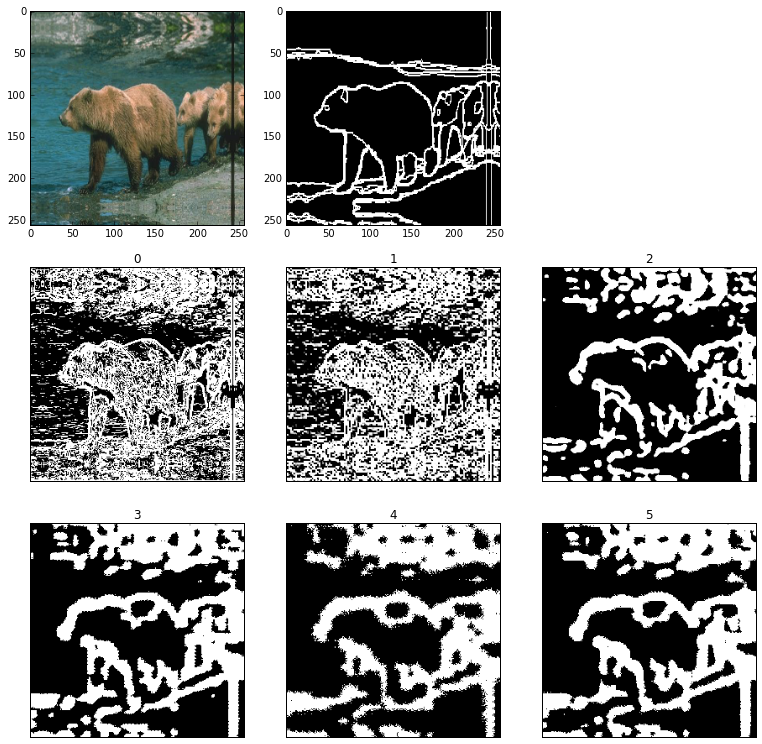

In [36]:
TestFiles = os.listdir('HED-BSDS/train/X/aug_data/0.0_1_0')
file = TestFiles[0]
file_or = 'HED-BSDS/train/X/aug_data/0.0_1_0/'+file
file_gt = 'HED-BSDS/train/Y/aug_gt/0.0_1_0/'+file[:-4]+'.png'

Img__ = (Y[0].reshape(256,256))*255#cv2.resize(asarray(PIL.Image.open(file_gt)),(128, 128))
Img_ = X[0]#cv2.resize(asarray(PIL.Image.open(file_or)),(128, 128))
Image_out = model.predict([Img_])
image_counter=0
fig = plt.figure(figsize=(13,13))
y = fig.add_subplot(3,3,1)
y.imshow(Img_)
y = fig.add_subplot(3,3,2)
y.imshow(Img__ ,cmap='gray')
while image_counter<6:
    I_print = Image_out[image_counter].reshape(256,256)
    y = fig.add_subplot(3,3,image_counter+4)
    y.imshow(I_print, cmap='gray')
    plt.title(image_counter)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    image_counter+=1
plt.show() 

### version 12

In [ ]:
TestFiles = os.listdir('HED-BSDS/train/X/aug_data/0.0_1_0')
file = TestFiles[0]
file_or = 'HED-BSDS/train/X/aug_data/0.0_1_0/'+file
file_gt = 'HED-BSDS/train/Y/aug_gt/0.0_1_0/'+file[:-4]+'.png'

Img__ = (Y[0].reshape(256,256))*255#cv2.resize(asarray(PIL.Image.open(file_gt)),(128, 128))
Img_ = YCan[0]#cv2.resize(asarray(PIL.Image.open(file_or)),(128, 128))
Image_out = model.predict([Img_])
image_counter=0
fig = plt.figure(figsize=(13,13))
y = fig.add_subplot(3,3,1)
y.imshow(Img_)
y = fig.add_subplot(3,3,2)
y.imshow(Img__ ,cmap='gray')
while image_counter<6:
    I_print = Image_out[image_counter].reshape(256,256)
    y = fig.add_subplot(3,3,image_counter+4)
    y.imshow(I_print, cmap='gray')
    plt.title(image_counter)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    image_counter+=1
plt.show() 

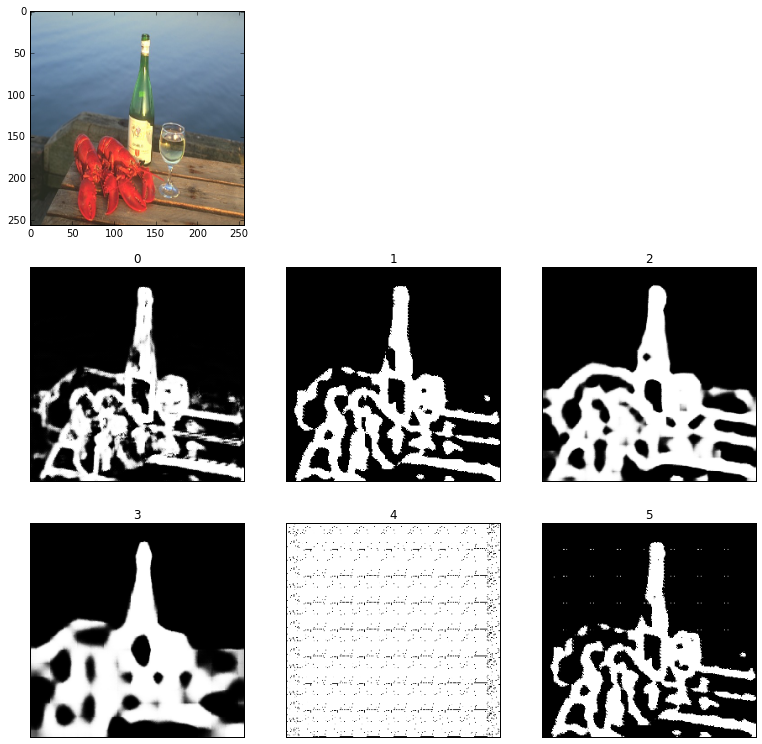

In [91]:
TestFiles = os.listdir('HED-BSDS/test')
file = TestFiles[50]
file_or = 'HED-BSDS/test/'+file
Img_ = cv2.resize(asarray(PIL.Image.open(file_or)),(256, 256))
Image_out = model.predict([Img_])
image_counter=0
fig = plt.figure(figsize=(13,13))
y = fig.add_subplot(3,3,1)
y.imshow(Img_)
#y = fig.add_subplot(3,3,2)
#y.imshow(Img__)
while image_counter<6:
    I_print = Image_out[image_counter].reshape(256,256)
    y = fig.add_subplot(3,3,image_counter+4)
    y.imshow(I_print, cmap='gray')
    plt.title(image_counter)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    image_counter+=1
plt.show() 

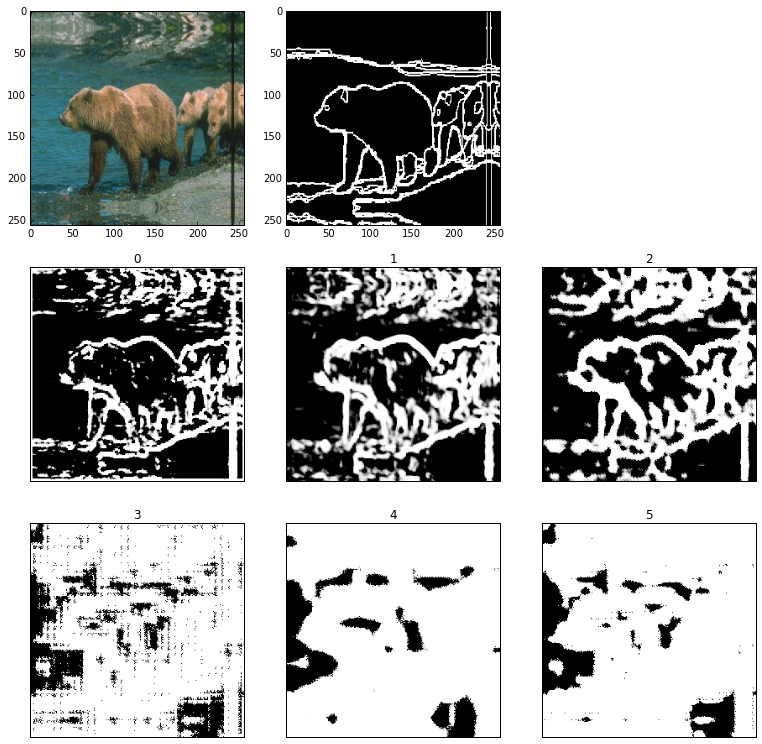

In [72]:
TestFiles = os.listdir('HED-BSDS/train/X/aug_data/0.0_1_0')
file = TestFiles[0]
file_or = 'HED-BSDS/train/X/aug_data/0.0_1_0/'+file
file_gt = 'HED-BSDS/train/Y/aug_gt/0.0_1_0/'+file[:-4]+'.png'

Img__ = (Y[0].reshape(256,256))*255#cv2.resize(asarray(PIL.Image.open(file_gt)),(128, 128))
Img_ = X[0]#cv2.resize(asarray(PIL.Image.open(file_or)),(128, 128))
Image_out = model.predict([Img_])
image_counter=0
fig = plt.figure(figsize=(13,13))
y = fig.add_subplot(3,3,1)
y.imshow(Img_)
y = fig.add_subplot(3,3,2)
y.imshow(Img__ ,cmap='gray')
while image_counter<6:
    I_print = Image_out[image_counter].reshape(256,256)
    y = fig.add_subplot(3,3,image_counter+4)
    y.imshow(I_print, cmap='gray')
    plt.title(image_counter)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    image_counter+=1
plt.show() 

### version 9

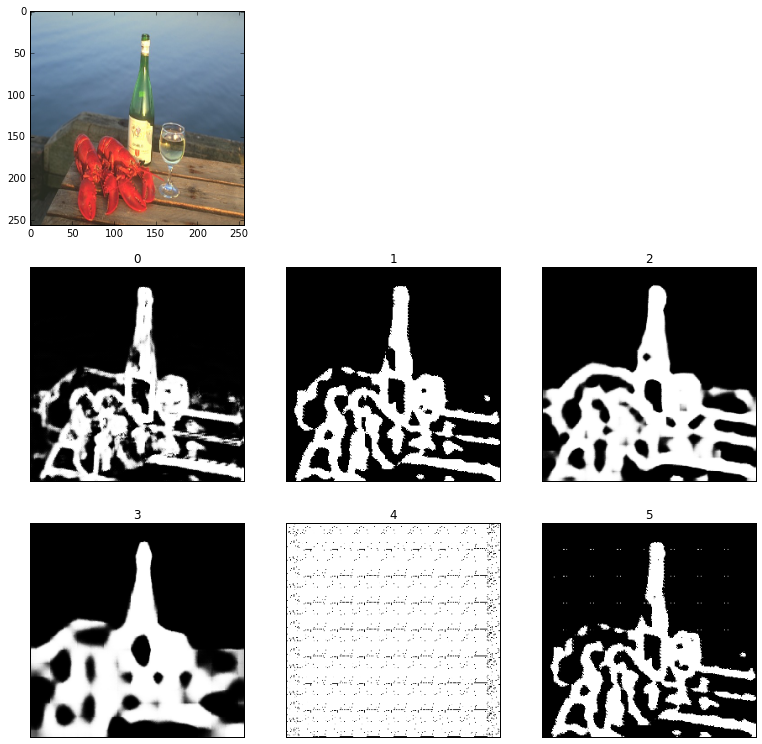

In [92]:
TestFiles = os.listdir('HED-BSDS/test')
file = TestFiles[50]
file_or = 'HED-BSDS/test/'+file
Img_ = cv2.resize(asarray(PIL.Image.open(file_or)),(256, 256))
Image_out = model.predict([Img_])
image_counter=0
fig = plt.figure(figsize=(13,13))
y = fig.add_subplot(3,3,1)
y.imshow(Img_)
#y = fig.add_subplot(3,3,2)
#y.imshow(Img__)
while image_counter<6:
    I_print = Image_out[image_counter].reshape(256,256)
    y = fig.add_subplot(3,3,image_counter+4)
    y.imshow(I_print, cmap='gray')
    plt.title(image_counter)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    image_counter+=1
plt.show() 

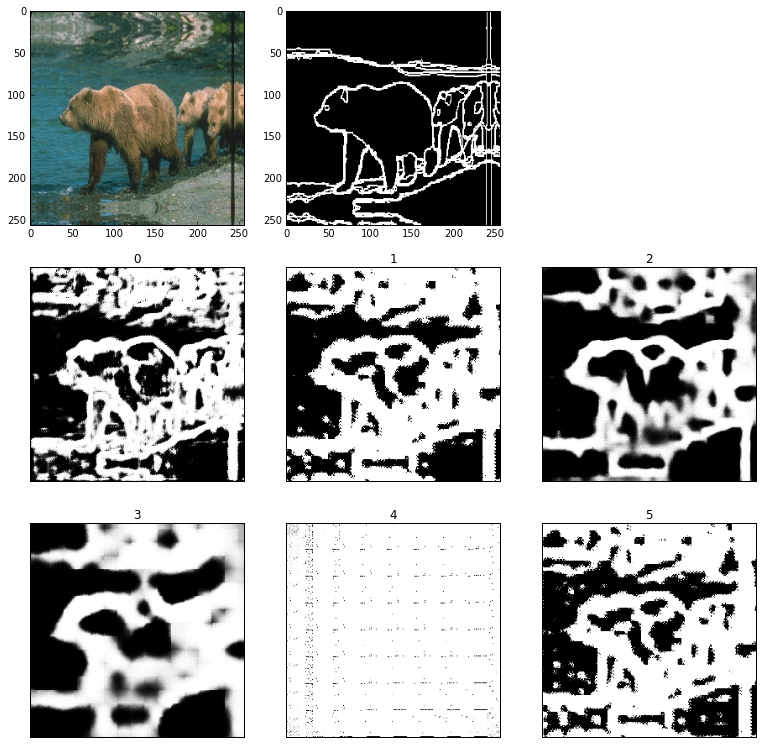

In [56]:
TestFiles = os.listdir('HED-BSDS/train/X/aug_data/0.0_1_0')
file = TestFiles[0]
file_or = 'HED-BSDS/train/X/aug_data/0.0_1_0/'+file
file_gt = 'HED-BSDS/train/Y/aug_gt/0.0_1_0/'+file[:-4]+'.png'

Img__ = (Y[0].reshape(256,256))*255#cv2.resize(asarray(PIL.Image.open(file_gt)),(128, 128))
Img_ = X[0]#cv2.resize(asarray(PIL.Image.open(file_or)),(128, 128))
Image_out = model.predict([Img_])
image_counter=0
fig = plt.figure(figsize=(13,13))
y = fig.add_subplot(3,3,1)
y.imshow(Img_)
y = fig.add_subplot(3,3,2)
y.imshow(Img__ ,cmap='gray')
while image_counter<6:
    I_print = Image_out[image_counter].reshape(256,256)
    y = fig.add_subplot(3,3,image_counter+4)
    y.imshow(I_print, cmap='gray')
    plt.title(image_counter)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    image_counter+=1
plt.show() 

In [46]:
np.max(Image_out)

1.0